In [29]:
!pip install mitdeeplearning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import mitdeeplearning as mdl

In [10]:
import tensorflow as tf

In [11]:
tf.__version__

'2.12.0'

In [12]:
import numpy as np
import matplotlib.pyplot as plt

## 1.1 Why is TensorFlow called TensorFlow?

In [13]:
matrix = tf.constant([[1.0, 2.0], [1.0, 2.0]])
assert isinstance(matrix, tf.Tensor), "matrix must be a tf Tensor object"
assert tf.rank(matrix).numpy() == 2

In [14]:
images = tf.zeros([10, 256, 256, 3])
assert isinstance(images, tf.Tensor), "matrix must be a tf Tensor object"
assert tf.rank(images).numpy() == 4, "matrix must be of rank 4"
assert tf.shape(images).numpy().tolist() == [10, 256, 256, 3], "matrix is incorrect shape"

## 1.2 Computations on Tensors

In [15]:
def func(a,b):
  c = tf.add(a,b)
  d = tf.subtract(b,1)
  e = tf.multiply(c,d)
  return e
a, b = 1.5, 2.5
e_out = func(a,b)
print(e_out)

tf.Tensor(6.0, shape=(), dtype=float32)


## 1.3 Neural networks in TensorFlow

In [33]:
class OurDenseLayer(tf.keras.layers.Layer):
  def __init__(self, n_output_nodes):
    super(OurDenseLayer, self).__init__()
    self.n_output_nodes = n_output_nodes

  def build(self, input_shape):
    d = int(input_shape[-1])
    # Define and initialize parameters: a weight matrix W and bias b
    # Note that parameter initialization is random!
    self.W = self.add_weight("weight", shape=[d, self.n_output_nodes]) # note the dimensionality
    self.b = self.add_weight("bias", shape=[1, self.n_output_nodes]) # note the dimensionality

  def call(self, x):
    '''TODO: define the operation for z (hint: use tf.matmul)'''
    print(tf.shape(self.W))
    z = tf.matmul(x, self.W)

    '''TODO: define the operation for out (hint: use tf.sigmoid)'''
    y = tf.sigmoid(tf.add(z, self.b))
    return y

# Since layer parameters are initialized randomly, we will set a random seed for reproducibility
tf.random.set_seed(1)
layer = OurDenseLayer(3)
layer.build((1,2))
x_input = tf.constant([[1,2.]], shape=(1,2))
y = layer.call(x_input)

# test the output!
print(y.numpy())
# mdl.lab1.test_custom_dense_layer_output(y)

tf.Tensor([2 3], shape=(2,), dtype=int32)
[[0.97624546 0.8357129  0.10415356]]


In [36]:
from keras.layers.serialization import activation
### Defining a neural network using the Sequential API ###

# Import relevant packages
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Define the number of outputs
n_output_nodes = 3

# First define the model 
model = Sequential()

'''TODO: Define a dense (fully connected) layer to compute z'''
# Remember: dense layers are defined by the parameters W and b!
# You can read more about the initialization of W and b in the TF documentation :) 
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense?version=stable
dense_layer = Dense(3, activation='sigmoid')

# Add the dense layer to the model
model.add(dense_layer)

In [39]:
### Defining a model using subclassing ###

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

class SubclassModel(tf.keras.Model):

  # In __init__, we define the Model's layers
  def __init__(self, n_output_nodes):
    super(SubclassModel, self).__init__()
    '''TODO: Our model consists of a single Dense layer. Define this layer.''' 
    self.dense_layer = tf.keras.layers.Dense(n_output_nodes, activation = 'sigmoid')

  # In the call function, we define the Model's forward pass.
  def call(self, inputs):
    return self.dense_layer(inputs)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
n_output_nodes = 3
model = SubclassModel(n_output_nodes)

x_input = tf.constant([[1,2.]], shape=(1,2))

print(model.call(x_input))

tf.Tensor([[0.21124151 0.8566307  0.7171847 ]], shape=(1, 3), dtype=float32)


In [41]:
### Defining a model using subclassing and specifying custom behavior ###

from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

class IdentityModel(tf.keras.Model):

  # As before, in __init__ we define the Model's layers
  # Since our desired behavior involves the forward pass, this part is unchanged
  def __init__(self, n_output_nodes):
    super(IdentityModel, self).__init__()
    self.dense_layer = tf.keras.layers.Dense(n_output_nodes, activation='sigmoid')

  '''TODO: Implement the behavior where the network outputs the input, unchanged, 
      under control of the isidentity argument.'''
  def call(self, inputs, isidentity=False):
    x = self.dense_layer(inputs)
    if isidentity:
      return inputs
    return x

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
n_output_nodes = 3
model = IdentityModel(n_output_nodes)

x_input = tf.constant([[1,2.]], shape=(1,2))
'''TODO: pass the input into the model and call with and without the input identity option.'''
out_activate = model.call(x_input, True)
out_identity = model.call(x_input)

print("Network output with activation: {}; network identity output: {}".format(out_activate.numpy(), out_identity.numpy()))

Network output with activation: [[1. 2.]]; network identity output: [[0.42508495 0.53776044 0.69646055]]


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 1.4 Automatic differentiation in TensorFlow

In [43]:
### Gradient computation with GradientTape ###

# y = x^2
# Example: x = 3.0
x = tf.Variable(3.0)

# Initiate the gradient tape
with tf.GradientTape() as tape:
  # Define the function
  y = x * x
# Access the gradient -- derivative of y with respect to x
dy_dx = tape.gradient(y, x)

assert dy_dx.numpy() == 6.0

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Initializing x=[[-0.45701224]]


Text(0, 0.5, 'x value')

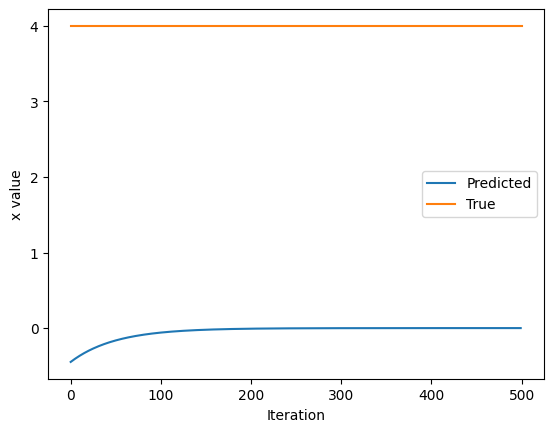

In [46]:
### Function minimization with automatic differentiation and SGD ###

# Initialize a random value for our initial x
x = tf.Variable([tf.random.normal([1])])
print("Initializing x={}".format(x.numpy()))

learning_rate = 1e-2 # learning rate for SGD
history = []
# Define the target value
x_f = 4

# We will run SGD for a number of iterations. At each iteration, we compute the loss, 
#   compute the derivative of the loss with respect to x, and perform the SGD update.
for i in range(500):
  with tf.GradientTape() as tape:
    '''TODO: define the loss as described above'''
    loss = x * x

  # loss minimization using gradient tape
  grad = tape.gradient(loss, x) # compute the derivative of the loss with respect to x
  new_x = x - learning_rate*grad # sgd update
  x.assign(new_x) # update the value of x
  history.append(x.numpy()[0])

# Plot the evolution of x as we optimize towards x_f!
plt.plot(history)
plt.plot([0, 500],[x_f,x_f])
plt.legend(('Predicted', 'True'))
plt.xlabel('Iteration')
plt.ylabel('x value')